## Imports

In [1]:
#General
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
import random
import time

#Image loading and processing
import os
from matplotlib import image
from skimage.transform import resize

#Model development
import tensorflow as tf
from tensorflow.keras import datasets, layers, models, optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input as VGG16_preprocess_input
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input as RN50_preprocess_input
from tensorflow.keras.optimizers import SGD

/anaconda3/envs/tensor_env/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/anaconda3/envs/tensor_env/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/anaconda3/envs/tensor_env/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/anaconda3/envs/tensor_env/lib/python3.7/site-packages/tensorflow/pyth

## Define functions

In [2]:
def generate_image_set(breed_list, clean='y', threshold = 0):

#Set up list of dog pics:
    path = 'dog_pics/'
    clean_path = 'clean_dog_pics/'
    file_list = sorted(os.listdir('dog_pics/'))
    file_list = file_list[1:]
    clean_file_list = sorted(os.listdir('clean_dog_pics/'))
    clean_file_list = clean_file_list[1:]

#Load pictures and labels from a specified breed list
    print('Loading pictures...')
    
    labels=[]
    images=list()
    for file in tqdm_notebook(clean_file_list):
        dog_breed=file[6:-7]
        pic_pc = int(file[:-4].split('_')[-1])
        if dog_breed in breed_list:
            if pic_pc >= threshold:
                if clean == 'y':
                    data = np.asarray(image.imread(clean_path+file))
                else:
                    load_filename = file[:-7]+'.jpg'
                    data = np.asarray(image.imread(path+load_filename))
                if data.shape!=(400,400,3):
                    data = resize(data,(400,400,3), anti_aliasing=True)
                images.append(data)
                labels.append(dog_breed)                
    print('Setting up numpy array')
    images = np.array(images)
    
    print('Number of loaded images: ',len(images))
    print('Number of labels: ', len(labels))

#Set up label dictionaries and convert labels from text to integers for modelling
    breed_dict = {}
    for i in range (0, len(breed_list)):
        breed_dict[breed_list[i]]=i
    print(breed_dict)
    inv_breed_dict = {}
    for i in range (0, len(breed_list)):
        inv_breed_dict[i]=breed_list[i]
    print(inv_breed_dict)
    int_labels = [breed_dict[breed] for breed in labels]


#Set up train test split
    print('Setting up train/test split')
    train_images, test_images, train_labels, test_labels =\
    train_test_split(images, int_labels, test_size = 0.2, 
                     random_state = 1, shuffle = True, stratify = int_labels)
    

#Pre-process pictures for modelling
    print('Pre-processing pictures')
    train_images, test_images = train_images / 255.0, test_images / 255.0

#Reminder of baseline (updated to reflect number of loaded images):
    baseline_scores=[]
    for label in list(set(test_labels)):
        number_of_images = test_labels.count(label)
        pc_of_images = number_of_images / len(test_labels)
        print(inv_breed_dict[label],'; number of images: ',
              number_of_images, '; % of images', pc_of_images)
        baseline_scores.append(pc_of_images)
    baseline = max(baseline_scores)
    print('Baseline: ', baseline)
    
    return train_images, test_images, train_labels, test_labels, inv_breed_dict, baseline

In [3]:
#Set up first model definition
#https://www.tensorflow.org/beta/tutorials/keras/basic_classification
def def_model1(outshape):
    model = models.Sequential([layers.Flatten(input_shape=(400, 400, 3)),
                               layers.Dense(128, activation='relu'),
                               layers.Dense(outshape, activation='softmax')])
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [4]:
#Set up second more complex model definition
#https://machinelearningmastery.com/how-to-develop-a-convolutional-neural-network-to-classify-satellite-photos-of-the-amazon-rainforest/
def def_model2(outshape):
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(400, 400, 3)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(outshape, activation='softmax'))

    model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
    return model

In [5]:
#Set up third model definition to include dropouts.
def def_model3(outshape):
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(400, 400, 3)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.2))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.2))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(outshape, activation='softmax'))

    model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
    es = EarlyStopping(monitor = 'val_acc', min_delta = 0.0001, restore_best_weights=True)
    return model, es

In [6]:
#Set up fourth model definition to include a further 2 layers.
def def_model4(outshape):
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(400, 400, 3)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.2))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.2))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.2))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.2))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(outshape, activation='softmax'))

    model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
    es = EarlyStopping(monitor = 'val_acc', min_delta = 0.0001, restore_best_weights=True)
    return model, es

In [7]:
#Define functions for reviewing results
def plot_image(i, predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array, true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    plt.imshow(img, cmap=plt.cm.binary)

    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
        color = 'green'
    else:
        color = 'red'

    plt.xlabel("{} {:2.0f}% ({})".format(inv_breed_dict[predicted_label],
                                100*np.max(predictions_array),
                                inv_breed_dict[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
    predictions_array, true_label = predictions_array, true_label[i]
    plt.grid(False)
    plt.xticks(range(len(predictions_array)))
    plt.yticks([])
    thisplot = plt.bar(range(len(predictions_array)), predictions_array, color="#777777")
    plt.ylim([0, 1])
    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
        thisplot[predicted_label].set_color('green')
        thisplot[true_label].set_color('green')
    if predicted_label != true_label:
        thisplot[predicted_label].set_color('red')
        thisplot[true_label].set_color('pink')

In [8]:
def review_results(predictions, test_labels, test_images, sample_size = 10):
    
    for counter in range(sample_size):
        i = random.randint(0,len(test_labels)-1)
        print(i)
        print(inv_breed_dict)
        plt.figure(figsize=(6,3))
        plt.subplot(1,2,1)
        plot_image(i, predictions[i], test_labels, test_images)
        plt.subplot(1,2,2)
        plot_value_array(i, predictions[i],  test_labels)
        plt.show()

In [9]:
def summarize_diagnostics(history):
    fig, ax = plt.subplots(nrows=2)
    # plot loss
    ax[0].plot(history.history['loss'], color='blue', label='train')
    ax[0].plot(history.history['val_loss'], color='orange', label='test')
    ax[0].set_title('Loss')
    # plot accuracy
    ax[1].plot(history.history['acc'], color='blue', label='train')
    ax[1].plot(history.history['val_acc'], color='orange', label='test')
    ax[1].set_title('Acc')
    fig.tight_layout()
    plt.show(); 

In [10]:
def model_documentation_nn(model_summary,
                           model, breed_list, training_sample_size,
                           pic_resolution, pic_masked, pic_quality,
                           baseline_score, validation_score,
                           train_score, test_score,
                           time_taken, notes):
    num_dog_breeds = len(breed_list)
    stringlist = []
    model.summary(print_fn=lambda x: stringlist.append(x))
    short_model_summary = "\n".join(stringlist)
    model_summary = model_summary.append({
        'model_type' : type(model),
        'model_parameters' : short_model_summary,
        'number_dog_breeds' : num_dog_breeds,
        'dog_breeds' : breed_list,
        'training_sample_size' : training_sample_size,
        'picture_resolution' : pic_resolution,
        'pictures_masked' : pic_masked,
        'picture_quality' : pic_quality,
        'baseline_score' : baseline_score,
        'validation_score' : validation_score,
        'train_score' : train_score,
        'test_score' : test_score,
        'time_taken' : time_taken,
        'notes' : notes},
        ignore_index = True)
#Display latest entry
    last_row = model_summary.shape[0]-1
    print(model_summary.iloc[last_row])
    return model_summary

## Set up dataset and model summary dataframe
3 breeds: labrador, cocker spaniel and french bulldog

In [11]:
breed_list = ['labrador', 'cocker_spaniel', 'french_bulldog']
clean = 'y'
threshold = 30
train_images, test_images, train_labels, test_labels, inv_breed_dict, baseline =\
generate_image_set(breed_list, clean, threshold)

Loading pictures...



Setting up numpy array
Number of loaded images:  2589
Number of labels:  2589
{'labrador': 0, 'cocker_spaniel': 1, 'french_bulldog': 2}
{0: 'labrador', 1: 'cocker_spaniel', 2: 'french_bulldog'}
Setting up train/test split
Pre-processing pictures
labrador ; number of images:  210 ; % of images 0.40540540540540543
cocker_spaniel ; number of images:  193 ; % of images 0.37258687258687256
french_bulldog ; number of images:  115 ; % of images 0.222007722007722
Baseline:  0.40540540540540543


In [12]:
#Set up temporary model summary dataframe
master_model_summary = pd.read_pickle('model_summary.pkl')
temp_model_summary = pd.DataFrame(columns=master_model_summary.columns)

## Model 1

In [13]:
start_time = time.time()
model = def_model1(len(breed_list))
history = model.fit(train_images, train_labels, epochs=20, validation_split=0.2)
print("Model accuracy")
max_val_acc = max(history.history['val_acc'])
train_acc = history.history['acc'][-2]
test_loss, test_acc = model.evaluate(test_images, test_labels)
model_time = time.time() - start_time

W0901 22:36:58.343220 4475307456 deprecation.py:506] From /anaconda3/envs/tensor_env/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Train on 1656 samples, validate on 415 samples
Epoch 1/20
1656/1656 [==============================] - 18s 11ms/sample - loss: 17.6182 - acc: 0.4058 - val_loss: 3.8878 - val_acc: 0.4096
Epoch 2/20
1656/1656 [==============================] - 14s 8ms/sample - loss: 2.0394 - acc: 0.5290 - val_loss: 1.8503 - val_acc: 0.4434
Epoch 3/20
1656/1656 [==============================] - 14s 9ms/sample - loss: 1.6198 - acc: 0.5700 - val_loss: 1.8768 - val_acc: 0.4048
Epoch 4/20
1656/1656 [==============================] - 14s 9ms/sample - loss: 1.0215 - acc: 0.6479 - val_loss: 1.7423 - val_acc: 0.4337
Epoch 5/20
1656/1656 [==============================] - 14s 9ms/sample - loss: 1.3885 - acc: 0.6171 - val_loss: 3.1729 - val_acc: 0.3880
Epoch 6/20
1656/1656 [==============================] - 14s 9ms/sample - loss: 0.9445 - acc: 0.6981 - val_loss: 1.7965 - val_acc: 0.4361
Epoch 7/20
1656/1656 [==============================] - 14s 9ms/sample - loss: 0.6687 - acc: 0.7572 - val_loss: 1.6615 - val_acc:

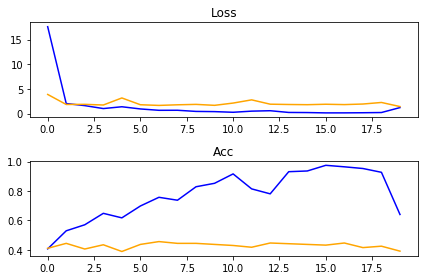

In [14]:
summarize_diagnostics(history)

In [15]:
notes = 'NN model 1'
temp_model_summary = model_documentation_nn(temp_model_summary, model,
                                            breed_list, len(train_images), 
                                            train_images[0].shape,
                                            clean, threshold,
                                            baseline, max_val_acc,
                                            train_acc, test_acc,
                                            model_time, notes)

model_type              <class 'tensorflow.python.keras.engine.sequent...
model_parameters        Model: "sequential"\n_________________________...
number_dog_breeds                                                       3
dog_breeds                     [labrador, cocker_spaniel, french_bulldog]
training_sample_size                                                 2071
picture_resolution                                          (400, 400, 3)
pictures_masked                                                         y
picture_quality                                                        30
baseline_score                                                   0.405405
validation_score                                                 0.455422
train_score                                                      0.927536
test_score                                                       0.409266
time_taken                                                        297.815
notes                                 

## Model 2

In [17]:
start_time = time.time()
model = def_model2(len(breed_list))
history = model.fit(train_images, train_labels, epochs=5, validation_split=0.2)
print("Model accuracy")
max_val_acc = max(history.history['val_acc'])
train_acc = history.history['acc'][-2]
test_loss, test_acc = model.evaluate(test_images, test_labels)
model_time = time.time() - start_time

Train on 1656 samples, validate on 415 samples
Epoch 1/5
1656/1656 [==============================] - 154s 93ms/sample - loss: 1.9664 - acc: 0.3998 - val_loss: 1.0297 - val_acc: 0.4361
Epoch 2/5
1656/1656 [==============================] - 134s 81ms/sample - loss: 0.9706 - acc: 0.5199 - val_loss: 0.9911 - val_acc: 0.4892
Epoch 3/5
1656/1656 [==============================] - 132s 80ms/sample - loss: 0.6709 - acc: 0.7228 - val_loss: 1.0345 - val_acc: 0.5277
Epoch 4/5
1656/1656 [==============================] - 130s 79ms/sample - loss: 0.2388 - acc: 0.9167 - val_loss: 1.3926 - val_acc: 0.5349
Epoch 5/5
1656/1656 [==============================] - 130s 78ms/sample - loss: 0.0476 - acc: 0.9891 - val_loss: 2.1066 - val_acc: 0.5518
Model accuracy
518/518 [==============================] - 15s 29ms/sample - loss: 2.0834 - acc: 0.5444


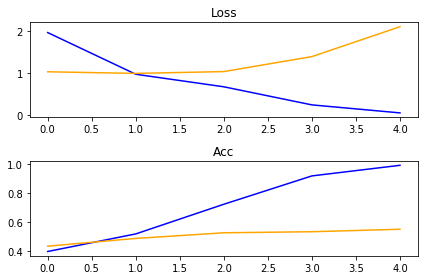

In [18]:
summarize_diagnostics(history)

In [19]:
notes = 'CNN model 1'
temp_model_summary = model_documentation_nn(temp_model_summary, model,
                                            breed_list, len(train_images), 
                                            train_images[0].shape,
                                            clean, threshold,
                                            baseline, max_val_acc,
                                            train_acc, test_acc,
                                            model_time, notes)

model_type              <class 'tensorflow.python.keras.engine.sequent...
model_parameters        Model: "sequential_2"\n_______________________...
number_dog_breeds                                                       3
dog_breeds                     [labrador, cocker_spaniel, french_bulldog]
training_sample_size                                                 2071
picture_resolution                                          (400, 400, 3)
pictures_masked                                                         y
picture_quality                                                        30
baseline_score                                                   0.405405
validation_score                                                 0.551807
train_score                                                      0.916667
test_score                                                       0.544402
time_taken                                                        696.485
notes                                 

In [20]:
model, es = def_model3(len(breed_list))
model.fit(train_images, train_labels, epochs=15, validation_split=0.2, callbacks = [es])
print("Model accuracy")
test_loss, test_acc = model.evaluate(test_images, test_labels)
predictions = model.predict(test_images)

Train on 1656 samples, validate on 415 samples
Epoch 1/15
1656/1656 [==============================] - 161s 97ms/sample - loss: 1.4259 - acc: 0.3943 - val_loss: 1.0803 - val_acc: 0.4096
Epoch 2/15
1656/1656 [==============================] - 154s 93ms/sample - loss: 1.0446 - acc: 0.4656 - val_loss: 1.0180 - val_acc: 0.4627
Epoch 3/15
1656/1656 [==============================] - 151s 91ms/sample - loss: 0.8089 - acc: 0.6522 - val_loss: 1.0048 - val_acc: 0.5277
Epoch 4/15
1656/1656 [==============================] - 151s 91ms/sample - loss: 0.4490 - acc: 0.8297 - val_loss: 1.1249 - val_acc: 0.5325
Epoch 5/15
1656/1656 [==============================] - 151s 91ms/sample - loss: 0.2130 - acc: 0.9130 - val_loss: 1.3919 - val_acc: 0.5470
Epoch 6/15
1656/1656 [==============================] - 151s 91ms/sample - loss: 0.1627 - acc: 0.9402 - val_loss: 1.4883 - val_acc: 0.5590
Epoch 7/15
1656/1656 [==============================] - 150s 91ms/sample - loss: 0.1151 - acc: 0.9577 - val_loss: 1.593

In [21]:
model, es = def_model3(len(breed_list))
model.fit(train_images, train_labels, epochs=15, validation_split=0.2, callbacks = [es])
print("Model accuracy")
test_loss, test_acc = model.evaluate(test_images, test_labels)
predictions = model.predict(test_images)

Train on 1656 samples, validate on 415 samples
Epoch 1/15
1656/1656 [==============================] - 168s 101ms/sample - loss: 1.2019 - acc: 0.3955 - val_loss: 1.0470 - val_acc: 0.4651
Epoch 2/15
1656/1656 [==============================] - 153s 92ms/sample - loss: 0.9925 - acc: 0.4988 - val_loss: 1.0071 - val_acc: 0.4940
Epoch 3/15
1656/1656 [==============================] - 152s 92ms/sample - loss: 0.6528 - acc: 0.7168 - val_loss: 1.0038 - val_acc: 0.5518
Epoch 4/15
1656/1656 [==============================] - 152s 92ms/sample - loss: 0.3504 - acc: 0.8696 - val_loss: 1.3099 - val_acc: 0.5494
Model accuracy
518/518 [==============================] - 16s 31ms/sample - loss: 0.9486 - acc: 0.5386


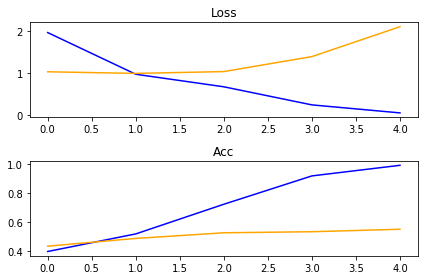

In [22]:
summarize_diagnostics(history)

In [23]:
notes = 'CNN model 2'
temp_model_summary = model_documentation_nn(temp_model_summary, model,
                                            breed_list, len(train_images), 
                                            train_images[0].shape,
                                            clean, threshold,
                                            baseline, max_val_acc,
                                            train_acc, test_acc,
                                            model_time, notes)

model_type              <class 'tensorflow.python.keras.engine.sequent...
model_parameters        Model: "sequential_4"\n_______________________...
number_dog_breeds                                                       3
dog_breeds                     [labrador, cocker_spaniel, french_bulldog]
training_sample_size                                                 2071
picture_resolution                                          (400, 400, 3)
pictures_masked                                                         y
picture_quality                                                        30
baseline_score                                                   0.405405
validation_score                                                 0.551807
train_score                                                      0.916667
test_score                                                        0.53861
time_taken                                                        696.485
notes                                 

## Model 3 - add drop outs and early stopping

In [24]:
start_time = time.time()
model, es = def_model3(len(breed_list))
history = model.fit(train_images, train_labels, epochs=10, 
                    validation_split=0.2, callbacks = [es])
print("Model accuracy")
max_val_acc = max(history.history['val_acc'])
train_acc = history.history['acc'][-2]
test_loss, test_acc = model.evaluate(test_images, test_labels)
model_time = time.time() - start_time

Train on 1656 samples, validate on 415 samples
Epoch 1/10
1656/1656 [==============================] - 170s 102ms/sample - loss: 1.2685 - acc: 0.3732 - val_loss: 1.0570 - val_acc: 0.4145
Epoch 2/10
1656/1656 [==============================] - 155s 94ms/sample - loss: 1.0053 - acc: 0.4601 - val_loss: 1.0128 - val_acc: 0.4747
Epoch 3/10
1656/1656 [==============================] - 152s 92ms/sample - loss: 0.8419 - acc: 0.6105 - val_loss: 1.0110 - val_acc: 0.5084
Epoch 4/10
1656/1656 [==============================] - 152s 92ms/sample - loss: 0.5656 - acc: 0.7627 - val_loss: 1.1611 - val_acc: 0.5518
Epoch 5/10
1656/1656 [==============================] - 153s 92ms/sample - loss: 0.3362 - acc: 0.8599 - val_loss: 1.4292 - val_acc: 0.5373
Model accuracy
518/518 [==============================] - 16s 32ms/sample - loss: 1.0949 - acc: 0.5656


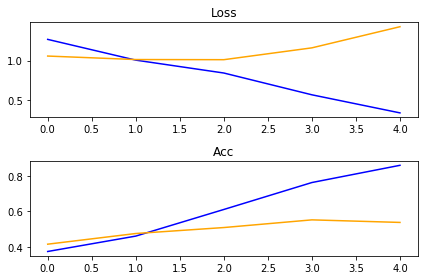

In [25]:
summarize_diagnostics(history)

In [26]:
notes = 'CNN model 3 - added drop outs'
temp_model_summary = model_documentation_nn(temp_model_summary, model,
                                            breed_list, len(train_images), 
                                            train_images[0].shape,
                                            clean, threshold,
                                            baseline, max_val_acc,
                                            train_acc, test_acc,
                                            model_time, notes)

model_type              <class 'tensorflow.python.keras.engine.sequent...
model_parameters        Model: "sequential_5"\n_______________________...
number_dog_breeds                                                       3
dog_breeds                     [labrador, cocker_spaniel, french_bulldog]
training_sample_size                                                 2071
picture_resolution                                          (400, 400, 3)
pictures_masked                                                         y
picture_quality                                                        30
baseline_score                                                   0.405405
validation_score                                                 0.551807
train_score                                                      0.762681
test_score                                                       0.565637
time_taken                                                        800.054
notes                                 

## Model 4 - add two layers to model

In [27]:
start_time = time.time()
model, es = def_model4(len(breed_list))
history = model.fit(train_images, train_labels, epochs=10, 
                    validation_split=0.2, callbacks = [es])
print("Model accuracy")
max_val_acc = max(history.history['val_acc'])
train_acc = history.history['acc'][-2]
test_loss, test_acc = model.evaluate(test_images, test_labels)
model_time = time.time() - start_time

Train on 1656 samples, validate on 415 samples
Epoch 1/10
1656/1656 [==============================] - 170s 103ms/sample - loss: 1.0984 - acc: 0.4004 - val_loss: 1.0776 - val_acc: 0.4120
Epoch 2/10
1656/1656 [==============================] - 161s 97ms/sample - loss: 1.0653 - acc: 0.4094 - val_loss: 1.0506 - val_acc: 0.4410
Epoch 3/10
1656/1656 [==============================] - 159s 96ms/sample - loss: 0.9860 - acc: 0.4758 - val_loss: 0.9851 - val_acc: 0.5036
Epoch 4/10
1656/1656 [==============================] - 159s 96ms/sample - loss: 0.9061 - acc: 0.5525 - val_loss: 0.9301 - val_acc: 0.5108
Epoch 5/10
1656/1656 [==============================] - 159s 96ms/sample - loss: 0.8181 - acc: 0.6075 - val_loss: 0.8572 - val_acc: 0.5639
Epoch 6/10
1656/1656 [==============================] - 159s 96ms/sample - loss: 0.7025 - acc: 0.6806 - val_loss: 0.8648 - val_acc: 0.6265
Epoch 7/10
1656/1656 [==============================] - 160s 96ms/sample - loss: 0.6089 - acc: 0.7120 - val_loss: 0.92

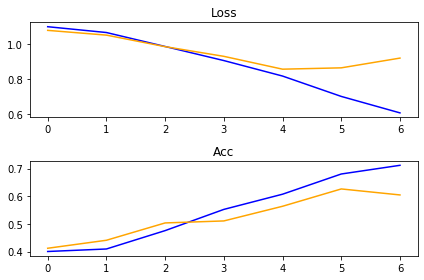

In [28]:
summarize_diagnostics(history)

In [29]:
notes = 'CNN model 4 - 2 extra layers'
temp_model_summary = model_documentation_nn(temp_model_summary, model,
                                            breed_list, len(train_images), 
                                            train_images[0].shape,
                                            clean, threshold,
                                            baseline, max_val_acc,
                                            train_acc, test_acc,
                                            model_time, notes)

model_type              <class 'tensorflow.python.keras.engine.sequent...
model_parameters        Model: "sequential_6"\n_______________________...
number_dog_breeds                                                       3
dog_breeds                     [labrador, cocker_spaniel, french_bulldog]
training_sample_size                                                 2071
picture_resolution                                          (400, 400, 3)
pictures_masked                                                         y
picture_quality                                                        30
baseline_score                                                   0.405405
validation_score                                                 0.626506
train_score                                                      0.680556
test_score                                                       0.621622
time_taken                                                        1144.33
notes                                 

## Use image augmentation on 3rd model
First check image data generator is working

In [30]:
train_datagen = ImageDataGenerator(validation_split=0.2)
train_generator = train_datagen.flow(train_images, train_labels, 
                                     subset='training', batch_size = 32)
val_datagen = ImageDataGenerator(validation_split=0.2)
val_generator = val_datagen.flow(train_images, train_labels, 
                                 subset='validation', batch_size = 32)

In [31]:
start_time = time.time()
model, es = def_model3(len(breed_list))
history = model.fit_generator(train_generator, 
                    epochs=15, 
                    validation_data = val_generator,
                    validation_steps =  0.2 * len(train_images) / 32,
                    callbacks = [es])
print("Model accuracy")
max_val_acc = max(history.history['val_acc'])
train_acc = history.history['acc'][-2]
test_loss, test_acc = model.evaluate(test_images, test_labels)
model_time = time.time() - start_time

Epoch 1/15
52/52 [==============================] - 153s 3s/step - loss: 1.6072 - acc: 0.3995 - val_loss: 1.0580 - val_acc: 0.4420
Epoch 2/15
52/52 [==============================] - 145s 3s/step - loss: 0.9710 - acc: 0.5124 - val_loss: 0.9526 - val_acc: 0.5097
Epoch 3/15
52/52 [==============================] - 144s 3s/step - loss: 0.6402 - acc: 0.7363 - val_loss: 0.9607 - val_acc: 0.5483
Epoch 4/15
52/52 [==============================] - 144s 3s/step - loss: 0.3128 - acc: 0.8829 - val_loss: 1.1615 - val_acc: 0.5676
Epoch 5/15
52/52 [==============================] - 144s 3s/step - loss: 0.1154 - acc: 0.9608 - val_loss: 1.6342 - val_acc: 0.5821
Epoch 6/15
52/52 [==============================] - 145s 3s/step - loss: 0.0898 - acc: 0.9710 - val_loss: 1.9480 - val_acc: 0.5676
Model accuracy
518/518 [==============================] - 16s 32ms/sample - loss: 1.9268 - acc: 0.5405


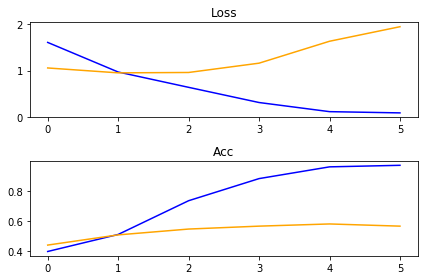

In [32]:
summarize_diagnostics(history)

Introduce first transformation - horizontal flip and random rotations.

### Test image augmentation

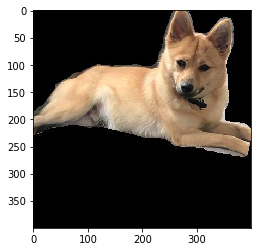

In [33]:
data = np.asarray(image.imread('clean_dog_pics/00003_pomchi_34.jpg'))
plt.imshow(data)

In [34]:
data = np.expand_dims(data, 0)
test_gen = ImageDataGenerator(horizontal_flip=True)
test_it = test_gen.flow(data, batch_size = 1)

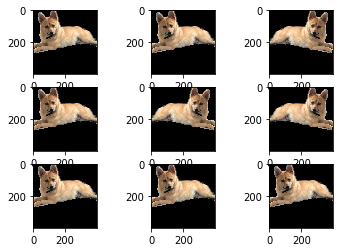

In [35]:
for i in range (9):
    plt.subplot(330+1+i)
    batch = test_it.next()
    pic = batch[0].astype('uint8')
    plt.imshow(pic)
plt.show()

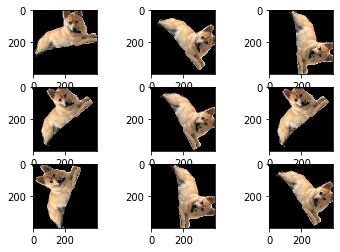

In [36]:
test_gen2 = ImageDataGenerator(rotation_range = 90, fill_mode='constant', cval = 0)
test_it2 = test_gen2.flow(data, batch_size = 1)
for i in range (9):
    plt.subplot(330+1+i)
    batch = test_it2.next()
    pic = batch[0].astype('uint8')
    plt.imshow(pic)
plt.show()

In [37]:
train_datagen = ImageDataGenerator(horizontal_flip=True,
                                   rotation_range = 90,
                                   fill_mode='constant',
                                   cval = 0,
                                   validation_split=0.2)
train_generator = train_datagen.flow(train_images, train_labels, subset='training', batch_size = 32)
val_datagen = ImageDataGenerator(validation_split=0.2)
val_generator = val_datagen.flow(train_images, train_labels, subset='validation', batch_size = 32)

In [38]:
start_time = time.time()
model, es = def_model3(len(breed_list))
es = EarlyStopping(monitor = 'val_acc', min_delta = 0.0001, 
                   patience=10, restore_best_weights=True)
history = model.fit_generator(train_generator, 
                    epochs=50, 
                    validation_data = val_generator,
                    validation_steps =  0.2 * len(train_images) / 32,
                    callbacks = [es])
print("Model accuracy")
best_model_index = history.history['val_acc'].index(max(history.history['val_acc']))
val_acc = history.history['val_acc'][best_model_index]
train_acc = history.history['acc'][best_model_index]
test_loss, test_acc = model.evaluate(test_images, test_labels)
model_time = time.time() - start_time

Epoch 1/50
52/52 [==============================] - 166s 3s/step - loss: 1.5287 - acc: 0.3935 - val_loss: 1.0802 - val_acc: 0.4106
Epoch 2/50
52/52 [==============================] - 144s 3s/step - loss: 1.0704 - acc: 0.3917 - val_loss: 1.0388 - val_acc: 0.4155
Epoch 3/50
52/52 [==============================] - 143s 3s/step - loss: 1.0466 - acc: 0.4218 - val_loss: 1.0270 - val_acc: 0.4058
Epoch 4/50
52/52 [==============================] - 144s 3s/step - loss: 1.0362 - acc: 0.4363 - val_loss: 0.9723 - val_acc: 0.4879
Epoch 5/50
52/52 [==============================] - 144s 3s/step - loss: 1.0186 - acc: 0.4472 - val_loss: 0.9717 - val_acc: 0.4831
Epoch 6/50
52/52 [==============================] - 143s 3s/step - loss: 1.0181 - acc: 0.4725 - val_loss: 0.9571 - val_acc: 0.4879
Epoch 7/50
52/52 [==============================] - 143s 3s/step - loss: 0.9880 - acc: 0.4906 - val_loss: 0.9634 - val_acc: 0.4879
Epoch 8/50
52/52 [==============================] - 144s 3s/step - loss: 0.9781 - a

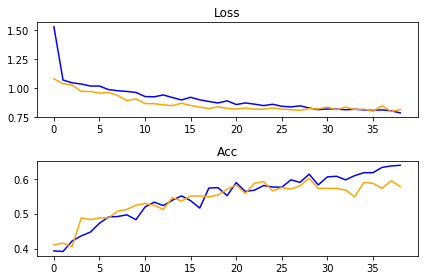

In [40]:
summarize_diagnostics(history)

In [41]:
notes = 'CNN model 3, image augmentation'
temp_model_summary = model_documentation_nn(temp_model_summary, model,
                                            breed_list, len(train_images), 
                                            train_images[0].shape,
                                            clean, threshold,
                                            baseline, max_val_acc,
                                            train_acc, test_acc,
                                            model_time, notes)

model_type              <class 'tensorflow.python.keras.engine.sequent...
model_parameters        Model: "sequential_8"\n_______________________...
number_dog_breeds                                                       3
dog_breeds                     [labrador, cocker_spaniel, french_bulldog]
training_sample_size                                                 2071
picture_resolution                                          (400, 400, 3)
pictures_masked                                                         y
picture_quality                                                        30
baseline_score                                                   0.405405
validation_score                                                 0.582126
train_score                                                      0.613156
test_score                                                       0.590734
time_taken                                                        5658.36
notes                                 

## Use image augmentation on 4th model

In [51]:
start_time = time.time()
model, es = def_model4(len(breed_list))
es = EarlyStopping(monitor = 'val_acc', min_delta = 0.0001, 
                   patience=10, restore_best_weights=True)
history = model.fit_generator(train_generator, 
                    epochs=50, 
                    validation_data = val_generator,
                    validation_steps =  0.2 * len(train_images) / 32,
                    callbacks = [es])
print("Model accuracy")
best_model_index = history.history['val_acc'].index(max(history.history['val_acc']))
val_acc = history.history['val_acc'][best_model_index]
train_acc = history.history['acc'][best_model_index]
test_loss, test_acc = model.evaluate(test_images, test_labels)
model_time = time.time() - start_time

Epoch 1/50
52/52 [==============================] - 152s 3s/step - loss: 22.4283 - acc: 0.3518 - val_loss: 1.1011 - val_acc: 0.4130
Epoch 2/50
52/52 [==============================] - 150s 3s/step - loss: 1.0894 - acc: 0.3941 - val_loss: 1.0974 - val_acc: 0.4130
Epoch 3/50
52/52 [==============================] - 150s 3s/step - loss: 1.0885 - acc: 0.3736 - val_loss: 1.0918 - val_acc: 0.4130
Epoch 4/50
52/52 [==============================] - 150s 3s/step - loss: 1.0889 - acc: 0.3959 - val_loss: 1.0899 - val_acc: 0.4130
Epoch 5/50
52/52 [==============================] - 150s 3s/step - loss: 1.0797 - acc: 0.3959 - val_loss: 1.0875 - val_acc: 0.4130
Epoch 6/50
52/52 [==============================] - 152s 3s/step - loss: 1.0848 - acc: 0.3772 - val_loss: 1.0833 - val_acc: 0.4130
Epoch 7/50
52/52 [==============================] - 154s 3s/step - loss: 1.0779 - acc: 0.4049 - val_loss: 1.0798 - val_acc: 0.4130
Epoch 8/50
52/52 [==============================] - 153s 3s/step - loss: 1.0773 - 

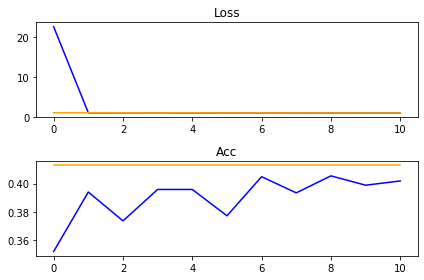

In [52]:
summarize_diagnostics(history)

In [53]:
notes = 'CNN model 4, image augmentation'
temp_model_summary = model_documentation_nn(temp_model_summary, model,
                                            breed_list, len(train_images), 
                                            train_images[0].shape,
                                            clean, threshold,
                                            baseline, max_val_acc,
                                            train_acc, test_acc,
                                            model_time, notes)

model_type              <class 'tensorflow.python.keras.engine.sequent...
model_parameters        Model: "sequential_11"\n______________________...
number_dog_breeds                                                       3
dog_breeds                     [labrador, cocker_spaniel, french_bulldog]
training_sample_size                                                 2071
picture_resolution                                          (400, 400, 3)
pictures_masked                                                         y
picture_quality                                                        30
baseline_score                                                   0.405405
validation_score                                                 0.582126
train_score                                                      0.351841
test_score                                                       0.405405
time_taken                                                        1683.31
notes                                 

## Transfer training with RN50 model and data augmentation

In [42]:
train_images_RN50 = RN50_preprocess_input(train_images)

In [43]:
test_images_RN50 = RN50_preprocess_input(test_images)

In [44]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(400,400,3))
add_model = models.Sequential()
add_model.add(layers.Flatten(input_shape=base_model.output_shape[1:]))
add_model.add(layers.Dense(512, activation='relu'))
# add_model.add(Dropout(0.5))
add_model.add(layers.Dense(len(set(train_labels)), activation='softmax'))
model = Model(inputs = base_model.input, outputs=add_model(base_model.output))
sgd = SGD(lr=0.001, decay = 1e-6, momentum = 0.9, nesterov=True)
model.compile(loss='sparse_categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

/anaconda3/envs/tensor_env/lib/python3.7/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [45]:
train_datagen = ImageDataGenerator(horizontal_flip=True,
                                   rotation_range = 90,
                                   fill_mode='constant',
                                   cval = 0,
                                   validation_split=0.2)
train_generator = train_datagen.flow(train_images_RN50, train_labels, subset='training', batch_size = 32)
val_datagen = ImageDataGenerator(validation_split=0.2)
val_generator = val_datagen.flow(train_images_RN50, train_labels, subset='validation', batch_size = 32)

In [46]:
start_time = time.time()
es = EarlyStopping(monitor = 'val_acc', min_delta = 0.0001, 
                   patience=5, restore_best_weights=True)
history = model.fit_generator(train_generator, 
                    epochs=15, 
                    validation_data = val_generator,
                    validation_steps =  0.2 * len(train_images) / 32,
                    callbacks = [es])
print("Model accuracy")
best_model_index = history.history['val_acc'].index(max(history.history['val_acc']))
val_acc = history.history['val_acc'][best_model_index]
train_acc = history.history['acc'][best_model_index]
test_loss, test_acc = model.evaluate(test_images, test_labels)
model_time = time.time() - start_time

Epoch 1/15
52/52 [==============================] - 1833s 35s/step - loss: 2.5699 - acc: 0.3724 - val_loss: 1.0691 - val_acc: 0.4130
Epoch 2/15
52/52 [==============================] - 1801s 35s/step - loss: 1.0834 - acc: 0.3959 - val_loss: 1.0925 - val_acc: 0.4130
Epoch 3/15
52/52 [==============================] - 1801s 35s/step - loss: 1.0778 - acc: 0.3887 - val_loss: 1.0861 - val_acc: 0.4130
Epoch 4/15
52/52 [==============================] - 1800s 35s/step - loss: 1.0790 - acc: 0.4104 - val_loss: 1.0788 - val_acc: 0.3816
Epoch 5/15
52/52 [==============================] - 1826s 35s/step - loss: 1.0822 - acc: 0.3983 - val_loss: 1.0721 - val_acc: 0.4130
Epoch 6/15
52/52 [==============================] - 1883s 36s/step - loss: 1.0835 - acc: 0.3959 - val_loss: 1.0834 - val_acc: 0.4130
Model accuracy
518/518 [==============================] - 85s 164ms/sample - loss: 1.0815 - acc: 0.4054


In [47]:
notes = 'RN50 Transfer training model'
temp_model_summary = model_documentation_nn(temp_model_summary, model,
                                            breed_list, len(train_images), 
                                            train_images[0].shape,
                                            clean, threshold,
                                            baseline, max_val_acc,
                                            train_acc, test_acc,
                                            model_time, notes)

model_type              <class 'tensorflow.python.keras.engine.trainin...
model_parameters        Model: "model"\n______________________________...
number_dog_breeds                                                       3
dog_breeds                     [labrador, cocker_spaniel, french_bulldog]
training_sample_size                                                 2071
picture_resolution                                          (400, 400, 3)
pictures_masked                                                         y
picture_quality                                                        30
baseline_score                                                   0.405405
validation_score                                                 0.582126
train_score                                                       0.37236
test_score                                                       0.405405
time_taken                                                        11033.3
notes                                 

In [54]:
temp_model_summary

,model_type,model_parameters,number_dog_breeds,dog_breeds,training_sample_size,picture_resolution,pictures_masked,picture_quality,baseline_score,validation_score,train_score,test_score,time_taken,notes
0,<class 'tensorflow.python.keras.engine.sequent...,"Model: ""sequential""\n_________________________...",3,"[labrador, cocker_spaniel, french_bulldog]",2071,"(400, 400, 3)",y,30,0.405405,0.455422,0.927536,0.409266,297.814807,NN model 1
1,<class 'tensorflow.python.keras.engine.sequent...,"Model: ""sequential_2""\n_______________________...",3,"[labrador, cocker_spaniel, french_bulldog]",2071,"(400, 400, 3)",y,30,0.405405,0.551807,0.916667,0.544402,696.484920,CNN model 1
2,<class 'tensorflow.python.keras.engine.sequent...,"Model: ""sequential_4""\n_______________________...",3,"[labrador, cocker_spaniel, french_bulldog]",2071,"(400, 400, 3)",y,30,0.405405,0.551807,0.916667,0.538610,696.484920,CNN model 2
3,<class 'tensorflow.python.keras.engine.sequent...,"Model: ""sequential_5""\n_______________________...",3,"[labrador, cocker_spaniel, french_bulldog]",2071,"(400, 400, 3)",y,30,0.405405,0.551807,0.762681,0.565637,800.053933,CNN model 3 - added drop outs
4,<class 'tensorflow.python.keras.engine.sequent...,"Model: ""sequential_6""\n_______________________...",3,"[labrador, cocker_spaniel, french_bulldog]",2071,"(400, 400, 3)",y,30,0.405405,0.626506,0.680556,0.621622,1144.334881,CNN model 4 - 2 extra layers
5,<class 'tensorflow.python.keras.engine.sequent...,"Model: ""sequential_8""\n_______________________...",3,"[labrador, cocker_spaniel, french_bulldog]",2071,"(400, 400, 3)",y,30,0.405405,0.582126,0.613156,0.590734,5658.358610,"CNN model 3, image augmentation"
6,<class 'tensorflow.python.keras.engine.trainin...,"Model: ""model""\n______________________________...",3,"[labrador, cocker_spaniel, french_bulldog]",2071,"(400, 400, 3)",y,30,0.405405,0.582126,0.372360,0.405405,11033.345386,RN50 Transfer training model
7,<class 'tensorflow.python.keras.engine.sequent...,"Model: ""sequential_11""\n______________________...",3,"[labrador, cocker_spaniel, french_bulldog]",2071,"(400, 400, 3)",y,30,0.405405,0.582126,0.351841,0.405405,1683.311979,"CNN model 4, image augmentation"


In [50]:
temp_model_summary.to_pickle('temp_model_summary.pkl')

## Save results to model summary dataframe 

In [55]:
model_summary = pd.read_pickle('model_summary.pkl')

In [56]:
model_summary.head()

,model_type,model_parameters,number_dog_breeds,dog_breeds,training_sample_size,picture_resolution,pictures_masked,picture_quality,baseline_score,validation_score,train_score,test_score,time_taken,notes
0,<class 'sklearn.linear_model.logistic.Logistic...,"{'C': 1.0, 'class_weight': None, 'dual': False...",3,"[labrador, cocker_spaniel, french_bulldog]",2071,"(400, 400, 3)",y,30,0.405405,0.472722,1.000000,0.463320,16.291416,PCA used - all components used for modelling
1,<class 'sklearn.linear_model.logistic.Logistic...,"{'Cs': [1e-10, 1e-09, 1e-08, 1e-07, 1e-06, 1e-...",3,"[labrador, cocker_spaniel, french_bulldog]",2071,"(400, 400, 3)",y,30,0.405405,None,0.710768,0.521236,20.899002,PCA used - all components used for modelling
2,<class 'sklearn.ensemble.forest.RandomForestCl...,"{'bootstrap': True, 'class_weight': 'balanced'...",3,"[labrador, cocker_spaniel, french_bulldog]",2071,"(400, 400, 3)",y,30,0.405405,0.471286,1.000000,0.480695,118.870963,PCA used - all components used for modelling
3,<class 'sklearn.ensemble.gradient_boosting.Gra...,"{'criterion': 'friedman_mse', 'init': None, 'l...",3,"[labrador, cocker_spaniel, french_bulldog]",2071,"(400, 400, 3)",y,30,0.405405,0.515214,0.983100,0.552124,546.449187,PCA used. No Gradient Boosting parameter tuning
4,<class 'sklearn.model_selection._search.GridSe...,"{'cv': 5, 'error_score': 'raise-deprecating', ...",3,"[labrador, cocker_spaniel, french_bulldog]",2071,"(400, 400, 3)",y,30,0.405405,0.496379,0.994206,0.490347,19.838007,PCA used. Gradient Boosting n_estimators tuned...


In [57]:
model_summary.shape

(19, 14)

In [58]:
model_summary = model_summary.append(temp_model_summary, ignore_index=True)
model_summary.tail()

,model_type,model_parameters,number_dog_breeds,dog_breeds,training_sample_size,picture_resolution,pictures_masked,picture_quality,baseline_score,validation_score,train_score,test_score,time_taken,notes
22,<class 'tensorflow.python.keras.engine.sequent...,"Model: ""sequential_5""\n_______________________...",3,"[labrador, cocker_spaniel, french_bulldog]",2071,"(400, 400, 3)",y,30,0.405405,0.551807,0.762681,0.565637,800.053933,CNN model 3 - added drop outs
23,<class 'tensorflow.python.keras.engine.sequent...,"Model: ""sequential_6""\n_______________________...",3,"[labrador, cocker_spaniel, french_bulldog]",2071,"(400, 400, 3)",y,30,0.405405,0.626506,0.680556,0.621622,1144.334881,CNN model 4 - 2 extra layers
24,<class 'tensorflow.python.keras.engine.sequent...,"Model: ""sequential_8""\n_______________________...",3,"[labrador, cocker_spaniel, french_bulldog]",2071,"(400, 400, 3)",y,30,0.405405,0.582126,0.613156,0.590734,5658.358610,"CNN model 3, image augmentation"
25,<class 'tensorflow.python.keras.engine.trainin...,"Model: ""model""\n______________________________...",3,"[labrador, cocker_spaniel, french_bulldog]",2071,"(400, 400, 3)",y,30,0.405405,0.582126,0.372360,0.405405,11033.345386,RN50 Transfer training model
26,<class 'tensorflow.python.keras.engine.sequent...,"Model: ""sequential_11""\n______________________...",3,"[labrador, cocker_spaniel, french_bulldog]",2071,"(400, 400, 3)",y,30,0.405405,0.582126,0.351841,0.405405,1683.311979,"CNN model 4, image augmentation"


In [59]:
model_summary.to_pickle('model_summary.pkl')